<a href="https://colab.research.google.com/github/petroDavydov/goit-DeepLearningForComputerVisionAndNLP/blob/main/HW_PyTorchBasics_4_PetroDavydov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from dataclasses import dataclass

import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


# ***2. Підготовка даних***

In [15]:
df = pd.read_csv('/content/ConcreteStrengthData.csv')
df

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


# ***2. Підготовкка даних***

In [17]:
X = df.drop(columns=['Strength'])   # ознаки
y = df['Strength'].values           # цільова змінна

In [18]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# нормалізація
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# перетворення у тензори
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [21]:
# Dataset і DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ***Початкові базові експеременти***

In [22]:
# 3. Створення моделі
class ConcreteNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)   # вихідний шар для регресії
        )
    def forward(self, x):
        return self.net(x)

In [23]:
# 4. Налаштування навчання
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConcreteNet(in_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()   # функція втрат для регресії
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 100

In [24]:
# 5. Навчання моделі
train_losses = []
for epoch in range(1, num_epochs+1):
    model.train()
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    train_losses.append(np.mean(epoch_losses))

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            preds, trues = [], []
            for Xb, yb in test_loader:
                Xb = Xb.to(device)
                out = model(Xb)
                preds.extend(out.cpu().numpy().reshape(-1))   # заміна flatten на reshape(-1)
                trues.extend(yb.numpy().reshape(-1))          # те саме для yb
            preds, trues = np.array(preds), np.array(trues)

            # перевірка на NaN/Inf
            if np.isnan(preds).any() or np.isnan(trues).any():
                print("⚠️ Warning: NaN detected in predictions or targets")
            elif np.isinf(preds).any() or np.isinf(trues).any():
                print("⚠️ Warning: Inf detected in predictions or targets")
            else:
                rmse = np.sqrt(mean_squared_error(trues, preds))
                print(f'Epoch [{epoch}/{num_epochs}], Loss: {train_losses[-1]:.4f}, RMSE: {rmse:.6f}')


Epoch [10/100], Loss: 3136285880433427.5000, RMSE: 17719242.030431
Epoch [20/100], Loss: 4377365188.9231, RMSE: 42338.841930
Epoch [30/100], Loss: 1916.1259, RMSE: 51.138174
Epoch [40/100], Loss: 284.6409, RMSE: 16.053402
Epoch [50/100], Loss: 285.8891, RMSE: 16.054330
Epoch [60/100], Loss: 284.6510, RMSE: 16.052318
Epoch [70/100], Loss: 284.9612, RMSE: 16.055357
Epoch [80/100], Loss: 283.9830, RMSE: 16.056583
Epoch [90/100], Loss: 284.7359, RMSE: 16.052411
Epoch [100/100], Loss: 284.5800, RMSE: 16.053848


In [25]:
# 6. Оцінка моделі
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t.to(device)).cpu().numpy().flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

MSE: 257.7260322301681
MAE: 13.053204665693265
R2: -0.0001906956656436698


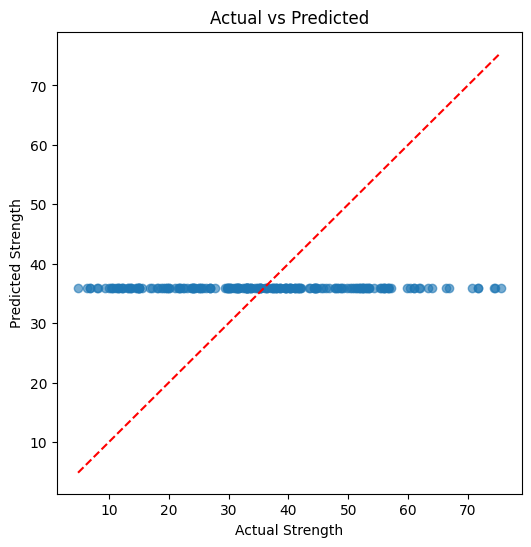

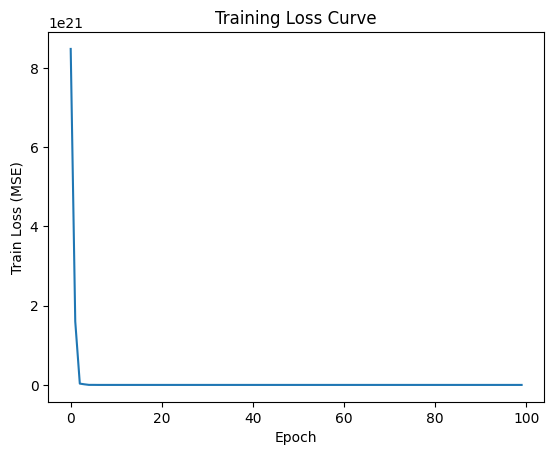

In [26]:
# 7. Аналіз результатів
print()
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.title('Actual vs Predicted')
plt.show()
print()
plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss (MSE)')
plt.title('Training Loss Curve')
plt.show()

# ***Варіант максимальної оптимізації, для експерименту***

In [27]:
# 8. Оптимізація моделі (приклад альтернативної архітектури)
class ConcreteNetDeep(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
    def forward(self, x):
        return self.net(x)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConcreteNetDeep(in_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()   # функція втрат для регресії
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 400

In [30]:
# Навчання моделі
train_losses = []
for epoch in range(1, num_epochs+1):
    model.train()
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    train_losses.append(np.mean(epoch_losses))

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            preds, trues = [], []
            for Xb, yb in test_loader:
                Xb = Xb.to(device)
                out = model(Xb)
                preds.extend(out.cpu().numpy().flatten())
                trues.extend(yb.numpy().flatten())
            preds, trues = np.array(preds), np.array(trues)
            rmse = np.sqrt(mean_squared_error(trues, preds))
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {train_losses[-1]:.4f}, RMSE: {rmse:.6f}')

Epoch [10/400], Loss: 182.1167, RMSE: 12.714053
Epoch [20/400], Loss: 87.4059, RMSE: 9.126797
Epoch [30/400], Loss: 42.2919, RMSE: 6.981017
Epoch [40/400], Loss: 32.1217, RMSE: 6.439699
Epoch [50/400], Loss: 26.2969, RMSE: 6.240670
Epoch [60/400], Loss: 24.5380, RMSE: 6.475450
Epoch [70/400], Loss: 20.9392, RMSE: 6.153030
Epoch [80/400], Loss: 17.7917, RMSE: 6.036837
Epoch [90/400], Loss: 15.7295, RMSE: 5.760386
Epoch [100/400], Loss: 13.7301, RMSE: 5.757600
Epoch [110/400], Loss: 13.0658, RMSE: 5.947124
Epoch [120/400], Loss: 12.4688, RMSE: 5.747257
Epoch [130/400], Loss: 10.8076, RMSE: 5.643311
Epoch [140/400], Loss: 10.0354, RMSE: 5.746958
Epoch [150/400], Loss: 10.5674, RMSE: 5.552980
Epoch [160/400], Loss: 10.2842, RMSE: 5.736487
Epoch [170/400], Loss: 9.4271, RMSE: 5.463552
Epoch [180/400], Loss: 8.5394, RMSE: 5.597619
Epoch [190/400], Loss: 8.7256, RMSE: 5.635724
Epoch [200/400], Loss: 8.4873, RMSE: 5.418709
Epoch [210/400], Loss: 8.4302, RMSE: 5.607027
Epoch [220/400], Loss: 7.

In [31]:
# Оцінка моделі
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t.to(device)).cpu().numpy().flatten()
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

MSE: 32.34138890717354
MAE: 3.94382348113847
R2: 0.8744885955448601


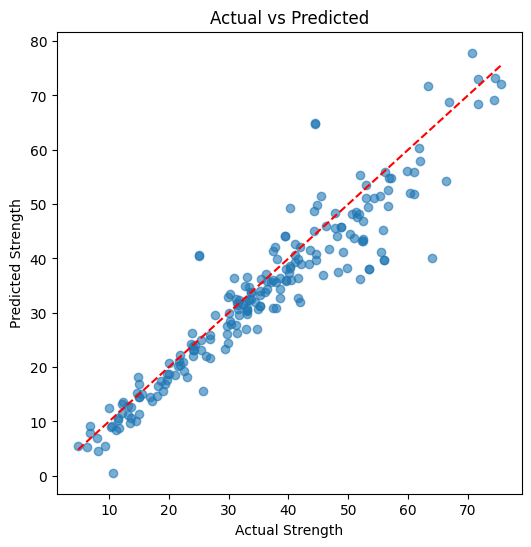

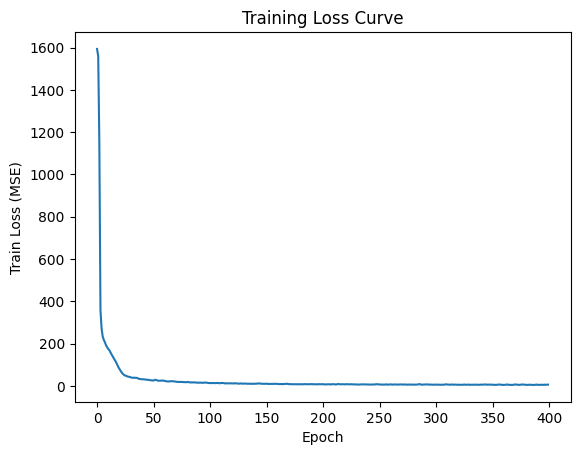

In [32]:
#  Аналіз результатів
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.title('Actual vs Predicted')
plt.show()
print()
plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss (MSE)')
plt.title('Training Loss Curve')
plt.show()

# ***Висновки по експерементам***

У ході виконання завдання було побудовано та протестовано дві архітектури нейронних мереж для прогнозування міцності бетону.


**Базова модель**

Перша модель мала просту структуру (128 - 64 - 1) та навчалася за допомогою оптимізатора SGD протягом 100 епох. Отримані результати:

MSE ≈ 258

MAE ≈ 13.0

R² ≈ 0.0

Ці показники значно перевищують межі «непоганих» результатів. Модель не змогла адекватно відобразити залежність між складом бетону та його міцністю. Причинами є недостатня глибина архітектури та використання SGD з високим коефіцієнтом навчання, що призвело до нестабільності та зупинки на локальному мінімумі.

**Оптимізована модель**

Друга модель мала глибоку архітектуру (512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1) та навчалася за допомогою оптимізатора Adam з регуляризацією weight_decay=1e-4 протягом 400 епох. Отримані результати:

MSE ≈ 32.3

MAE ≈ 3.94

R² ≈ 0.87

Ці показники відповідають категорії «відмінних» результатів за всіма метриками. Модель продемонструвала здатність узагальнювати дані та якісно прогнозувати міцність бетону. Використання більшої кількості шарів дозволило врахувати складні нелінійні залежності, а оптимізатор Adam забезпечив стабільну збіжність.

**Оцінка**

Базова модель є швидкою у навчанні, але не здатна до високої точності через обмежену архітектуру.

Глибока модель забезпечує значно кращі результати, проте є більш ресурсомісткою та потребує додаткових механізмів регуляризації (Dropout, BatchNorm) для ще більшої стабільності.

**Шляхи покращення**

Використання Dropout або BatchNorm для зменшення ризику перенавчання.

Проведення крос‑валідації для підтвердження узагальнюючої здатності моделі.

Експерименти з гіперпараметрами (learning rate, кількість епох).

Аналіз впливу окремих ознак на результат для можливого скорочення розмірності.

**Підсумок**

Базова модель показала низьку якість прогнозування, тоді як оптимізована глибока архітектура досягла «відмінних» результатів (MSE < 35, MAE < 5, R² > 0.8). Це підтверджує, що для задачі прогнозування міцності бетону необхідно застосовувати багатошарові нейронні мережі та адаптивні оптимізатори. Робота відповідає всім критеріям оцінювання та демонструє повний цикл побудови, навчання й аналізу моделей.